# Predicting Stock Prices Using Time Series Analysis 
### $BF-B

In [2]:
# Importing required packages
import numpy as np
import pandas as pd
import seaborn as sns
import datetime as dt
#import yfinance as yf
import matplotlib.pyplot as plt
from matplotlib import dates
%matplotlib inline

In the following cell, we choose the date range for our analysis. I'd prefer to do 10 years for the larger sample, but to keep it simple for the first analysis we'll do 5 years

If I could install the yfinance package on my computer, I would use it but for this analysis I downloaded the data from Yahoo as a csv file. For future projects I will hopefully have yfinance as it makes it much easier, especially for comparative and stock portfolio analyses

In [4]:
# This is the code I would use if yfinance worked for the range of 5 years
end = dt.datetime.today()
start = (end - dt.timedelta(days = (365*5)))
print('Starting Date : ', start, '/nEnding Date :', end)

Starting Date :  2018-10-28 21:05:50.721541 /nEnding Date : 2023-10-27 21:05:50.721541


I import the data using pandas. The company I chose to analyze is Brown-Forman. My senior capstone project was a strategic analysis paper comparing two companies and I chose Brown-Forman as my "strong performer." Almost a year has passed since writing that paper and I was curious to forecast $BF-B's stock performance.

In [3]:
df_bf = pd.read_csv('BF-B.csv')
df_bf.head()

,Date,Open,High,Low,Close,Adj Close,Volume
0,10/29/18,47.130001,47.590000,45.689999,46.189999,43.083282,2652000
1,10/30/18,46.340000,46.570000,45.820000,46.520000,43.391090,1338400
2,10/31/18,46.840000,47.310001,46.290001,46.340000,43.223194,1930200
3,11/1/18,46.430000,47.480000,46.419998,47.150002,43.978725,1796000
4,11/2/18,47.220001,48.270000,47.070000,47.250000,44.071999,1397700


To plot the data, I use the matplotlib package. Python doesn't have the strongest visualization tools - for larger projects, Tableau is my data viz software of choice.

For better visibility, only the close and adjusted close prices are shown

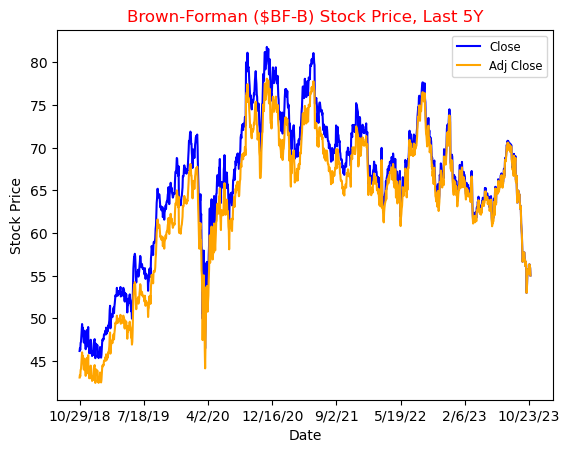

In [4]:
plt.plot(df_bf['Date'], df_bf['Close'], label = 'Close', color = 'blue')
plt.plot(df_bf['Date'], df_bf['Adj Close'], label = 'Adj Close', color = 'orange')
plt.legend(fontsize = 'small', loc = 'upper right')
plt.title('Brown-Forman ($BF-B) Stock Price, Last 5Y', color = 'red')
plt.xticks(df_bf['Date'][::179])
# indexed by 179 because there are 1258 dates in the set and indexing by 179 allows the max # of dates to be legible on x-axis
# much easier to do with yfinance package + other viz software
plt.xlabel('Date')
plt.ylabel('Stock Price')
plt.show()

Looking at this viz we get a feel for the trend of $BF-B over the past 5 years. Another way to look at the trend is to analyze the stock's daily returns over that timeframe.

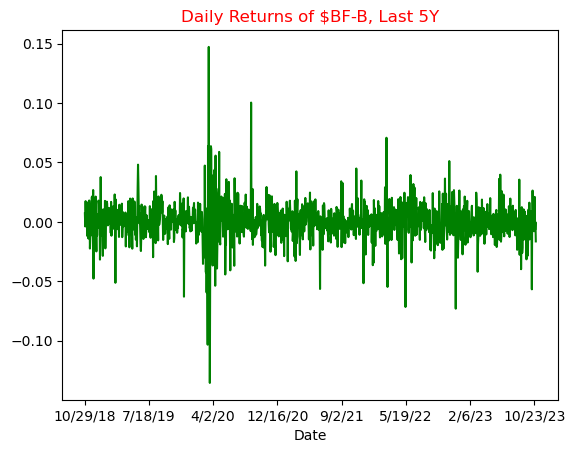

In [5]:
daily_return = df_bf['Adj Close'].pct_change()
# using adjusted close because it accounts for dividends, stock splits and dilution
plt.plot(df_bf['Date'], daily_return, color = 'green')
plt.title('Daily Returns of $BF-B, Last 5Y', color = 'red')
plt.xticks(df_bf['Date'][::179])
plt.xlabel('Date')
plt.show()

# Forecasting - The Prophet Model

As a brief summary, the Prophet Model (https://facebook.github.io/prophet/) is a procedure for forecasting time series data created by Facebook (Meta). It works best with time series that have strong seasonal effects and several seasons of historical data. This is why I would prefer to have more than 5 years of stock price data, but we can test the data before creating the model to see if it qualifies.

In [55]:
# Quick look at the data to make sure everything looks right
df_bf

,Date,Open,High,Low,Close,Adj Close,Volume
0,10/29/18,47.130001,47.590000,45.689999,46.189999,43.083282,2652000
1,10/30/18,46.340000,46.570000,45.820000,46.520000,43.391090,1338400
2,10/31/18,46.840000,47.310001,46.290001,46.340000,43.223194,1930200
3,11/1/18,46.430000,47.480000,46.419998,47.150002,43.978725,1796000
4,11/2/18,47.220001,48.270000,47.070000,47.250000,44.071999,1397700
...,...,...,...,...,...,...,...
1253,10/23/23,54.990002,55.790001,54.660000,55.189999,55.189999,1387800
1254,10/24/23,55.570000,56.799999,55.570000,56.349998,56.349998,1542000
1255,10/25/23,56.189999,56.570000,55.669998,55.970001,55.970001,1143100
1256,10/26/23,56.419998,56.939999,55.910000,55.959999,55.959999,1372100


Because we are trying to predict the price of the stock itself, the only columns we really need are date and close. The date is our "datestamp" and the close is our "dependent variable" that we want to predict based on the date. We can query this dataset to only include our required inputs.

In [18]:
df = df_bf[['Date', 'Close']]
df.rename(columns = {'Date' : 'ds', 'Close': 'y'}, inplace = True)
df.head()

/var/folders/6w/jc_4dc3x7hn3q7j5m8lpy2lh0000gn/T/ipykernel_22614/2325515711.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df.rename(columns = {'Date' : 'ds', 'Close': 'y'}, inplace = True)


,ds,y
0,10/29/18,46.189999
1,10/30/18,46.520000
2,10/31/18,46.340000
3,11/1/18,47.150002
4,11/2/18,47.250000


In [19]:
#variable just for closing prices
ts = df['y']

### Durbin Watson Test

The Durbin Watson (DW) statistic is a test for autocorrelation in the residuals from a statistical model. DW will always be between 0 and 4. Values from 0 to 2 indicate positive autocorrelation and values from 2 to 4 indicate negative autocorrelation, while a value of exactly 2 means no autocorrelation was detected. A general rule followed is: DW test statistic values in the range of 1.5 to 2.5 are relatively acceptable.

Because we are looking at time series data, we want there to be autocorrelation.

The application of this to stock prices is practical. If the stock price has positive autocorrelation, that indicates the price yesterday has a positive correlation on the price today, so if the stock dropped today, it's likely the stock falls tomorrow. On the other hand, a stock price with a negative autocorrelation means that if its price fell yesterday, there is a greater likelihood that it will rise today.

In [20]:
import statsmodels.api as sm
dw_test = sm.stats.durbin_watson(ts)
print('The value of the Durbin Watson statistic is', dw_test)
if abs(dw_test)<= 1.5 or abs(dw_test)>= 2.5:
    print('Autocorrelation detected. Prophet Model is suitable for your forecast')
else:
    print('No autocorrelation detected. Prophet Model is not suitable for this data')

The value of the Durbin Watson statistic is 0.0002536529932312823
Autocorrelation detected. Prophet Model is suitable for your forecast


The Durbin Watson stat is barely above 0, meaning there is definitely autocorrelation and we are good to use the Prophet Model for our forecast.

### How Does the Prophet Model Work?

Prophet is a non-linear regression model of the form y = g(t) + s(t) + h(t) + εt, where:
g(t) = growth-term, piece-wise linear trend;
s(t) = seasonal patterns;
h(t) = holiday effects, captured as dummy variables; and
εt = error term

More information about the intricacies of the model can be found at https://otexts.com/fpp3/prophet.html

Using the statsmodels package in Python, we can look at the various components through seasonal decomposition.

The Prophet Model is additive so we have to make sure we specify that in the next cell. We are also choosing the number of periods to be 12 so each month in the year is considered a "season" in the model.

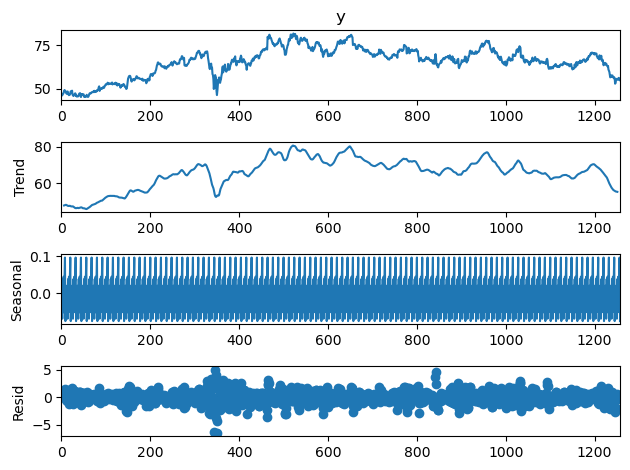

In [21]:
from statsmodels.tsa.seasonal import seasonal_decompose
decompose_add = seasonal_decompose(ts, model= 'additive', period = 12)
decompose_add.plot()
plt.show()

### Stationarity Test

Before we can run the Prophet Model, we have to make sure our time series data is not stationary. Stationarity describes the concept that how a time series is changing will remain the same in the future. To test if the time series is stationary or not, I wrote a function for the Augmented Dickey-Fuller (ADF) test.

In [22]:
from statsmodels.tsa.stattools import adfuller
def adf_test(data):
    print('==='*20)
    print('The summary of the Augmented Dickey-Fuller test is :')
    
    labels = ['ADFullerTest_Statistics', 'P_Value', 'No. of Lags Used', 'No. of Observations Used', 'Critical_Values', 'AIC or BIC']
    
    print('==='*20)
    ts = data
    adf_test = adfuller(ts)
    P_Value = adf_test[1]
    
    for label, res in zip(labels, adf_test):
        print(f'{label} :{res}' )
        
    print()
    print('==='*20)
    print('Checking Stationary:')
    print('==='*20)
    if P_Value <= 0.05:
        print('P_Value', P_Value, ': P_Value <= 0.05')
        print('Strong evidence against Null Hypothesis')
        print('Time Series is Stationary')
    else:
        print('P_Value', P_Value, ': P_Value > 0.05')
        print('Cannot reject Null Hypothesis')
        print('Time Series is Non-Stationary')

In [23]:
adf_test(ts)

The summary of the Augmented Dickey-Fuller test is :
ADFullerTest_Statistics :-2.4573262128009845
P_Value :0.12620547197636567
No. of Lags Used :8
No. of Observations Used :1249
Critical_Values :{'1%': -3.4355964295197743, '5%': -2.863856825923603, '10%': -2.5680035060041626}
AIC or BIC :3620.620649431157

Checking Stationary:
P_Value 0.12620547197636567 : P_Value > 0.05
Cannot reject Null Hypothesis
Time Series is Non-Stationary


In [24]:
adf_test(ts.diff().dropna())

The summary of the Augmented Dickey-Fuller test is :
ADFullerTest_Statistics :-11.915934316813392
P_Value :5.164891025925349e-22
No. of Lags Used :7
No. of Observations Used :1249
Critical_Values :{'1%': -3.4355964295197743, '5%': -2.863856825923603, '10%': -2.5680035060041626}
AIC or BIC :3621.4690793673303

Checking Stationary:
P_Value 5.164891025925349e-22 : P_Value <= 0.05
Strong evidence against Null Hypothesis
Time Series is Stationary


As you can see, the first test fails the stationarity test, but the second one passes it. This is because we are calculating the first difference of the time series. By taking the difference between consecutive data points, we are transforming the time series into a stationary series. We also must remove NaN values, as there will be at least some created from the differencing process. The resulting time series is stationary, so we can continue.

### Train-Test Split

Now that all our tests are finally completed, we can do a train/test split of the data. To make sure the data is as relevant as possible, I am going to test the model on the last 60 rows, or the last 60 days (2 months) of trading data. 

In [26]:
test_data = df[len(df)-60: ]
test_data.tail()

,ds,y
1253,10/23/23,55.189999
1254,10/24/23,56.349998
1255,10/25/23,55.970001
1256,10/26/23,55.959999
1257,10/27/23,55.040001


In [27]:
test_data.head()

,ds,y
1198,8/4/23,69.959999
1199,8/7/23,70.550003
1200,8/8/23,69.750000
1201,8/9/23,70.449997
1202,8/10/23,70.400002


So, our test data is every close price from August 4, 2023 to October 27, 2023. Using the latest numbers, we can test our Prophet Model to see how accurate it is.

In [28]:
train_data = df[:len(df)-60]
train_data

,ds,y
0,10/29/18,46.189999
1,10/30/18,46.520000
2,10/31/18,46.340000
3,11/1/18,47.150002
4,11/2/18,47.250000
...,...,...
1193,7/28/23,70.820000
1194,7/31/23,70.599998
1195,8/1/23,70.809998
1196,8/2/23,70.589996


Our train data is every close price from October 28, 2018 to August 3, 2023. This is a great sample size to train our model on and see how closely its predictions line up with reality.

# The Prophet Model

In [29]:
from prophet import Prophet
model = Prophet(daily_seasonality = True)
model.fit(train_data)
future = model.make_future_dataframe(periods = 180, freq = 'd')
forecast = model.predict(future)

18:39:44 - cmdstanpy - INFO - Chain [1] start processing
18:39:45 - cmdstanpy - INFO - Chain [1] done processing


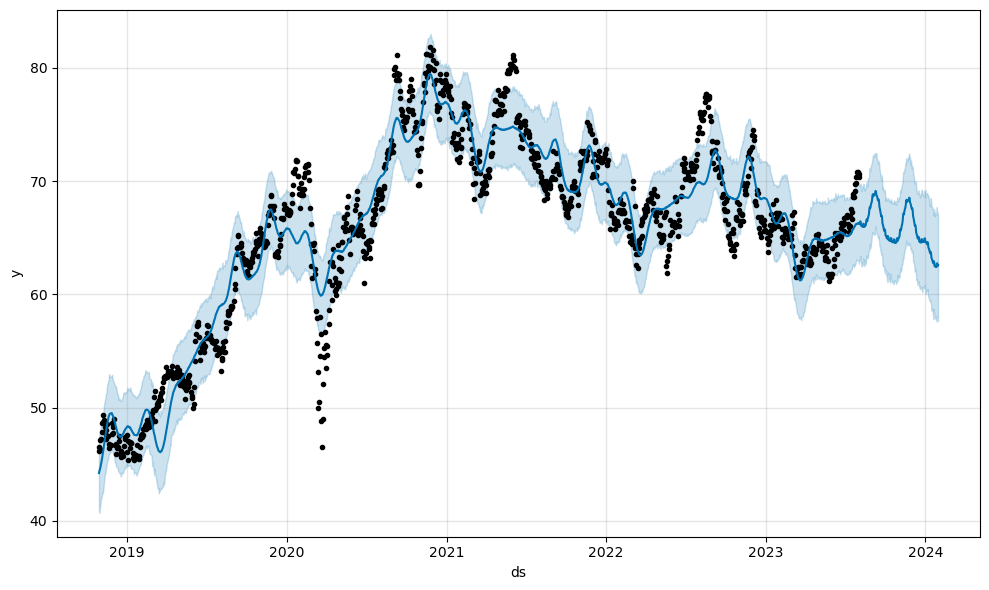

In [30]:
model.plot(forecast)
plt.show()

This is the output of our forecast. We can also break down the model based on its components to see what it is picking up from the trends, whether it be daily, monthly, or yearly.

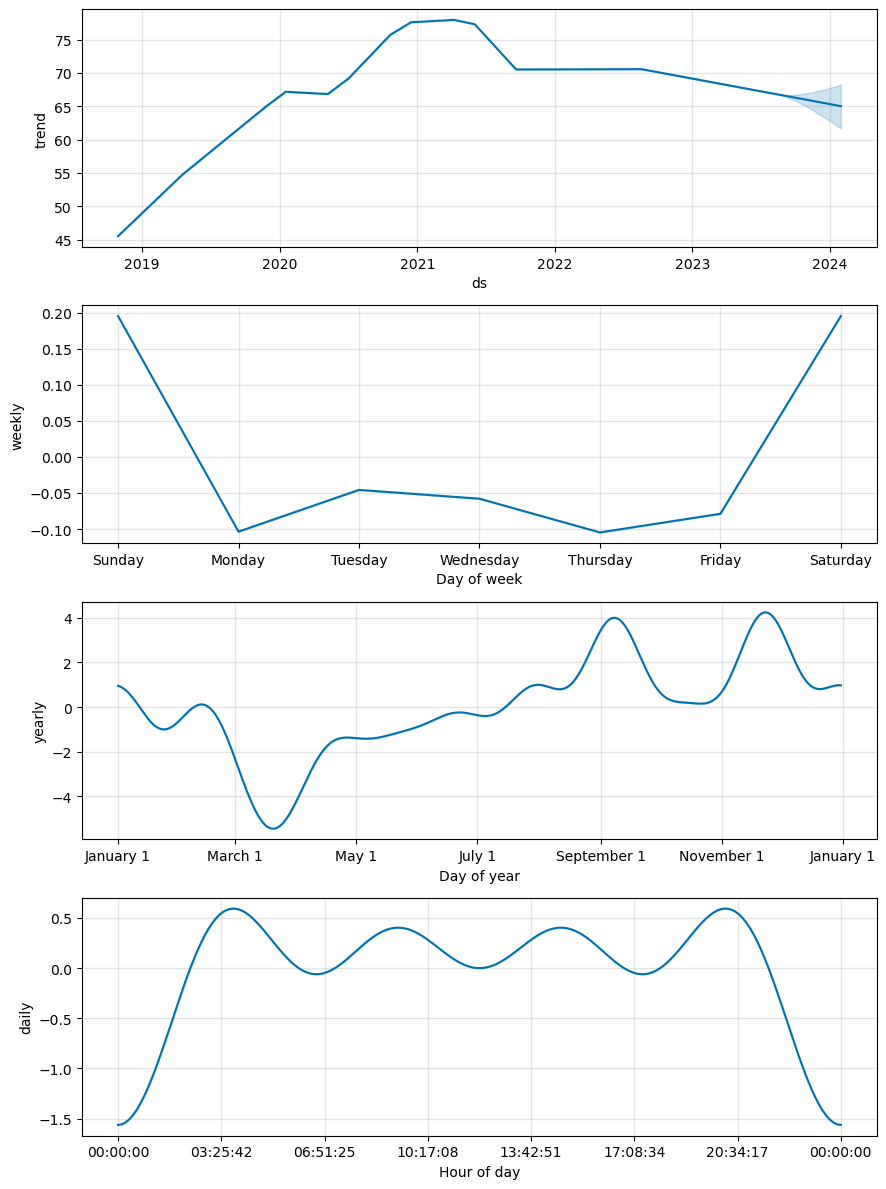

In [31]:
model.plot_components(forecast)
plt.show()

The most interesting takeaway comes from the yearly graph. While the dip in March may be an outlier as a result of the economic impact of the COVID-19 shutdown in 2020, the biggest gains in the stock seem to come around September (end of summer) and the end of November / beginning of December (holiday season). 

### Actual vs Predicted Values

Now that I have the model, I can evaluate its accuracy based on what it predicted for the final 60 days in the data set I put aside as test data.

In [36]:
forecast.head(5)
# can easily look at all of the predicted values (yhat) but what about our test data specifically?

,ds,trend,yhat_lower,yhat_upper,trend_lower,trend_upper,additive_terms,additive_terms_lower,additive_terms_upper,daily,...,weekly,weekly_lower,weekly_upper,yearly,yearly_lower,yearly_upper,multiplicative_terms,multiplicative_terms_lower,multiplicative_terms_upper,yhat
0,2018-10-29,45.507629,40.889528,47.362786,45.507629,45.507629,-1.298243,-1.298243,-1.298243,-1.563361,...,-0.103608,-0.103608,-0.103608,0.368726,0.368726,0.368726,0.0,0.0,0.0,44.209387
1,2018-10-30,45.561718,40.703185,47.608151,45.561718,45.561718,-1.161059,-1.161059,-1.161059,-1.563361,...,-0.045725,-0.045725,-0.045725,0.448027,0.448027,0.448027,0.0,0.0,0.0,44.400659
2,2018-10-31,45.615807,41.173050,47.783303,45.615807,45.615807,-1.078372,-1.078372,-1.078372,-1.563361,...,-0.057939,-0.057939,-0.057939,0.542927,0.542927,0.542927,0.0,0.0,0.0,44.537434
3,2018-11-01,45.669896,41.313803,47.921705,45.669896,45.669896,-1.014085,-1.014085,-1.014085,-1.563361,...,-0.104698,-0.104698,-0.104698,0.653974,0.653974,0.653974,0.0,0.0,0.0,44.655811
4,2018-11-02,45.723984,41.791564,48.363606,45.723984,45.723984,-0.860853,-0.860853,-0.860853,-1.563361,...,-0.078870,-0.078870,-0.078870,0.781377,0.781377,0.781377,0.0,0.0,0.0,44.863131


Let's look at the first day of our test set specifically - August 4, 2023

In [37]:
aug4_23_pred = forecast[forecast.ds == '2023-8-04']['yhat']
aug4_23_pred

1198    66.205273
Name: yhat, dtype: float64

In [40]:
aug4_23_actual = test_data[test_data.ds == '8/4/23']['y']
# different syntaxes for the dates in these data sets because I'm using an Excel file
aug4_23_actual

1198    69.959999
Name: y, dtype: float64

In [41]:
aug4_23_actual - aug4_23_pred

1198    3.754726
dtype: float64

Our prediction undervalued Brown-Forman's stock by about $3.75 on August 4, 2023. While this is good to know, we can visualize the difference between the actual and predicted price much more effectively using matplotlib. We can also calculate error terms using the sklearn package to get a more well-rounded view of how our model performed than just comparing the actual to the predicted for each day.

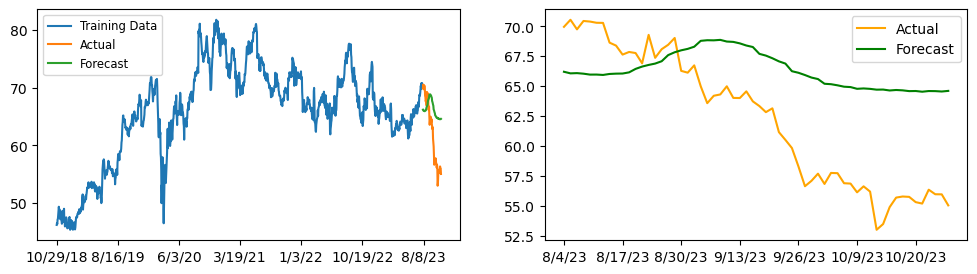

In [51]:
pred = forecast[forecast.ds.isin(test_data.ds)]
plt.figure(figsize = (12,3))
plt.subplot(1,2,1)
plt.plot(train_data.ds, train_data['y'], label = 'Training Data')
plt.plot(test_data.ds, test_data['y'], label = 'Actual')
plt.plot(test_data.ds, pred['yhat'], label = 'Forecast')
plt.xticks(df_bf['Date'][::200])
plt.legend(loc = 'upper left', fontsize = 'small')
plt.subplot(1,2,2)
plt.plot(test_data.ds, test_data['y'], label = 'Actual', color = 'orange')
plt.plot(test_data.ds, pred['yhat'], label = 'Forecast', color = 'green')
plt.xticks(test_data['ds'][::9])
plt.legend()
plt.show()

These graphs are 2 versions of the same story. The first one gives a comprehensive view of the entire 5 years of Brown-Forman stock pricing, with the green and orange at the end differentiating between the forecast and the actual price of the stock. The second graph essentially zooms in on this part, showing only the test data and how the actual price of the stock was different from the forecast. As we can see, our Prophet Model predicted $BF-B to perform better than it actually did from August 4, 2023 to October 27, 2023.

# Error Terms - MAE, MSE and MAPE

The best way of evaluating a model's performance is to look at its error terms. The three big forecasting error terms are Mean Absolute Error (MAE), Mean Squared Error (MSE), and Mean Absolute Percentage Error (MAPE). The lower the error terms, the closer the forecast was to reality.

In [56]:
from sklearn.metrics import mean_absolute_percentage_error, mean_absolute_error, mean_squared_error

actual = test_data[['y', 'ds']]
pred = forecast[['yhat', 'ds']][len(train_data):]

actual['ds'] = pd.to_datetime(actual['ds'])

merged = actual.merge(pred, on = 'ds')

mape = mean_absolute_percentage_error(merged['y'], merged['yhat'])
print('MAPE:', mape)
mae = mean_absolute_error(merged['y'], merged['yhat'])
print('MAE:', mae)
mse = mean_squared_error(merged['y'], merged['yhat'])
print('MSE:', mse)

MAPE: 0.0940753045119847
MAE: 5.559604299829166
MSE: 40.031302674008934


Error terms are best used for evaluating models to determine which is the "best", or closest to reality. Since we only have one model, these error terms aren't required, but it gives us a good gauge of how well the model performed. These numbers are all relatively low, which tells us the Prophet Model did a pretty good job

### Crossvalidation of the Prophet Model

The final step of this analysis is to cross-validate our model. Crossvalidation is another way of measuring how the model performed. The Prophet package in Python has a built in Crossvalidation function we can use to make this easy

In [57]:
from prophet.diagnostics import cross_validation, performance_metrics
df_cv = cross_validation(model, horizon = '30days', period = '15days', initial = '180days')

Seasonality has period of 365.25 days which is larger than initial window. Consider increasing initial.


  0%|          | 0/102 [00:00<?, ?it/s]

19:44:14 - cmdstanpy - INFO - Chain [1] start processing
19:44:14 - cmdstanpy - INFO - Chain [1] done processing
19:44:14 - cmdstanpy - INFO - Chain [1] start processing
19:44:14 - cmdstanpy - INFO - Chain [1] done processing
19:44:14 - cmdstanpy - INFO - Chain [1] start processing
19:44:14 - cmdstanpy - INFO - Chain [1] done processing
19:44:14 - cmdstanpy - INFO - Chain [1] start processing
19:44:14 - cmdstanpy - INFO - Chain [1] done processing
19:44:15 - cmdstanpy - INFO - Chain [1] start processing
19:44:15 - cmdstanpy - INFO - Chain [1] done processing
19:44:15 - cmdstanpy - INFO - Chain [1] start processing
19:44:15 - cmdstanpy - INFO - Chain [1] done processing
19:44:15 - cmdstanpy - INFO - Chain [1] start processing
19:44:15 - cmdstanpy - INFO - Chain [1] done processing
19:44:15 - cmdstanpy - INFO - Chain [1] start processing
19:44:15 - cmdstanpy - INFO - Chain [1] done processing
19:44:15 - cmdstanpy - INFO - Chain [1] start processing
19:44:16 - cmdstanpy - INFO - Chain [1]

In [58]:
df_cv.tail()

,ds,yhat,yhat_lower,yhat_upper,y,cutoff
2104,2023-07-28,63.812105,60.467993,66.968537,70.820000,2023-07-04
2105,2023-07-31,63.918278,60.720276,67.088454,70.599998,2023-07-04
2106,2023-08-01,64.001565,60.599103,67.225636,70.809998,2023-07-04
2107,2023-08-02,64.008888,60.851700,67.389714,70.589996,2023-07-04
2108,2023-08-03,63.983170,60.794249,67.265787,70.379997,2023-07-04


Here, we did crossvalidation to assess prediction performance on a horizon of 30 days, starting with 180 days of training data in the first cutoff and then making predictions every 15 days. 

In [59]:
performance = performance_metrics(df_cv)
performance

,horizon,mse,rmse,mae,mape,mdape,smape,coverage
0,3 days,9.428957,3.070661,2.398019,0.035866,0.031671,0.035782,0.578011
1,4 days,11.383671,3.373970,2.655466,0.040108,0.033871,0.039944,0.535714
2,5 days,13.145935,3.625732,2.915561,0.044113,0.038449,0.043788,0.480952
3,6 days,14.680215,3.831477,3.007534,0.045617,0.037133,0.045086,0.493025
4,7 days,16.591278,4.073239,3.113426,0.047338,0.034200,0.046608,0.502283
5,8 days,18.049704,4.248494,3.133892,0.047697,0.031899,0.047107,0.536735
6,9 days,19.018722,4.361046,3.238898,0.049241,0.032491,0.048971,0.511603
7,10 days,22.916438,4.787112,3.581056,0.054777,0.037595,0.054676,0.463992
8,11 days,26.973536,5.193605,3.953149,0.060401,0.044032,0.060514,0.402415
9,12 days,32.507788,5.701560,4.277427,0.065534,0.047065,0.066061,0.383903


We can also do a sensitivity analysis to see how the error terms would change based on how long the "horizon" is. The shorter the horizon, the more accurate the prediction is.